# Data Transformation
Topics
- Data Deduplication
- Replacing Values
- Discretization and Binning
- Missing Data Handling
- Outlier Detection
- Maximum Likelihood Estimation

## Requirements

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import zscore, norm
from scipy.optimize import minimize

In [23]:
file_path = "KosteckiDillon.csv"
data = pd.read_csv(file_path)

airq_data = data["airq"].dropna()

## Transformations

### Initial details

In [24]:
print("Dataset dimensions:", data.shape)
print("Initial missing values:\n", data.isna().sum())

Dataset dimensions: (4152, 10)
Initial missing values:
 rownames      0
id            0
time          0
dos           0
hatype        0
age           0
airq          0
medication    0
headache      0
sex           0
dtype: int64


### Summary statistics

In [25]:
print("Summary of the dataset:\n", data.describe())

Summary of the dataset:
           rownames           id         time          dos          age  \
count  4152.000000  4152.000000  4152.000000  4152.000000  4152.000000   
mean   2076.500000    66.386802    15.455684   646.705925    42.363921   
std    1198.723488    39.121812    21.737211   335.770123    11.201244   
min       1.000000     1.000000   -29.000000    98.000000    18.000000   
25%    1038.750000    33.000000     3.000000   384.000000    33.000000   
50%    2076.500000    67.000000    12.000000   623.000000    44.000000   
75%    3114.250000   100.000000    24.000000   950.000000    50.000000   
max    4152.000000   133.000000    99.000000  1239.000000    66.000000   

              airq  
count  4152.000000  
mean     24.826012  
std       9.514274  
min       3.000000  
25%      18.000000  
50%      24.000000  
75%      29.000000  
max      73.000000  


### Data Deduplication


In [26]:
print("Duplicates before removal:", data.duplicated().sum())
data.drop_duplicates(inplace=True)
print("Duplicates after removal:", data.duplicated().sum())

Duplicates before removal: 0
Duplicates after removal: 0


### Replacing specific values (e.g., replace 'yes' with 1, 'no' with 0 for 'headache')

In [27]:
data['headache'] = data['headache'].replace({'yes': 1, 'no': 0})
data

C:\Users\aathe\AppData\Local\Temp\ipykernel_11636\3866192071.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data['headache'] = data['headache'].replace({'yes': 1, 'no': 0})


,rownames,id,time,dos,hatype,age,airq,medication,headache,sex
0,1,1,-11,753,Aura,30,9.0,continuing,1,female
1,2,1,-10,754,Aura,30,7.0,continuing,1,female
2,3,1,-9,755,Aura,30,10.0,continuing,1,female
3,4,1,-8,756,Aura,30,13.0,continuing,1,female
4,5,1,-7,757,Aura,30,18.0,continuing,1,female
...,...,...,...,...,...,...,...,...,...,...
4147,4148,133,44,1232,Aura,26,20.0,continuing,1,male
4148,4149,133,45,1233,Aura,26,27.0,continuing,0,male
4149,4150,133,46,1234,Aura,26,28.0,continuing,0,male
4150,4151,133,47,1235,Aura,26,33.0,continuing,0,male


### Discretization and Binning: Bin 'age' into groups

In [28]:
data['age_bin'] = pd.cut(data['age'], bins=3, labels=["Young", "Middle-aged", "Senior"])
print("Age bins distribution:\n", data['age_bin'].value_counts())

Age bins distribution:
 age_bin
Middle-aged    1941
Young          1191
Senior         1020
Name: count, dtype: int64


### Missing Data Handling

In [29]:
print("Missing data before handling:\n", data.isna().sum())

# Imputation for numeric columns
numeric_cols = data.select_dtypes(include=[np.number]).columns
imputer = SimpleImputer(strategy="mean")
data[numeric_cols] = imputer.fit_transform(data[numeric_cols])


Missing data before handling:
 rownames      0
id            0
time          0
dos           0
hatype        0
age           0
airq          0
medication    0
headache      0
sex           0
age_bin       0
dtype: int64


### Outlier Detection and Handling using Z-Score


In [30]:
outliers = {}
for col in numeric_cols:
    z_scores = zscore(data[col])
    outliers[col] = np.where(np.abs(z_scores) > 3)[0]

# Replace outliers with NaN and impute them
for col, indices in outliers.items():
    if len(indices) > 0:
        data.loc[indices, col] = np.nan
        data[col] = imputer.fit_transform(data[[col]])

print("Missing data after handling:\n", data.isna().sum())

Missing data after handling:
 rownames      0
id            0
time          0
dos           0
hatype        0
age           0
airq          0
medication    0
headache      0
sex           0
age_bin       0
dtype: int64


### Visualizations

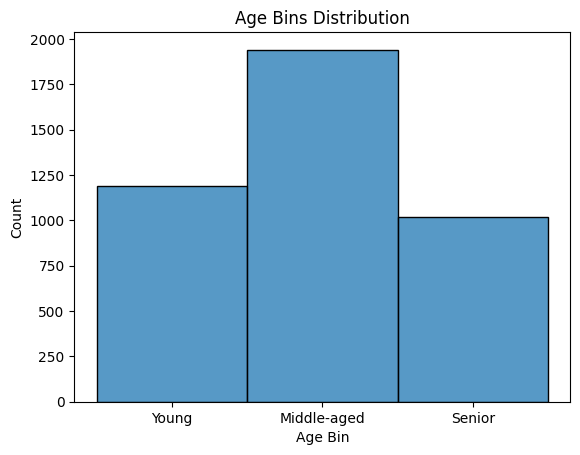

In [31]:
# Binning Visualization for Age
sns.histplot(data['age_bin'], kde=False)
plt.title("Age Bins Distribution")
plt.xlabel("Age Bin")
plt.ylabel("Count")
plt.show()

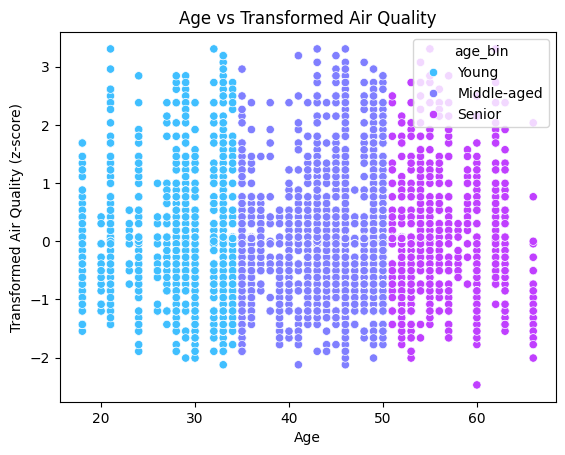

In [32]:
# Scatter plot for 'age' vs 'airq' with transformed data
data['airq_transformed'] = zscore(data['airq'])
sns.scatterplot(data=data, x='age', y='airq_transformed', hue='age_bin', palette='cool')
plt.title("Age vs Transformed Air Quality")
plt.xlabel("Age")
plt.ylabel("Transformed Air Quality (z-score)")
plt.show()

## Maximum Likelihood Estimation

In [33]:
# Defining the negative log-likelihood function for a normal distribution
def negative_log_likelihood(params, data):
    mu, sigma = params
    if sigma <= 0:  # Ensurglu standard deviation is positive
        return np.inf
    log_likelihood = np.sum(norm.logpdf(data, loc=mu, scale=sigma))
    return -log_likelihood  # Returnglu negative for minimization

In [34]:
initial_params = [airq_data.mean(), airq_data.std()]

result = minimize(negative_log_likelihood, initial_params, args=(airq_data,))
mle_mu, mle_sigma = result.x

print(f"MLE Estimated Mean (mu): {mle_mu}")
print(f"MLE Estimated Standard Deviation (sigma): {mle_sigma}")

MLE Estimated Mean (mu): 24.826011616934892
MLE Estimated Standard Deviation (sigma): 9.513127991824005


### Visualization

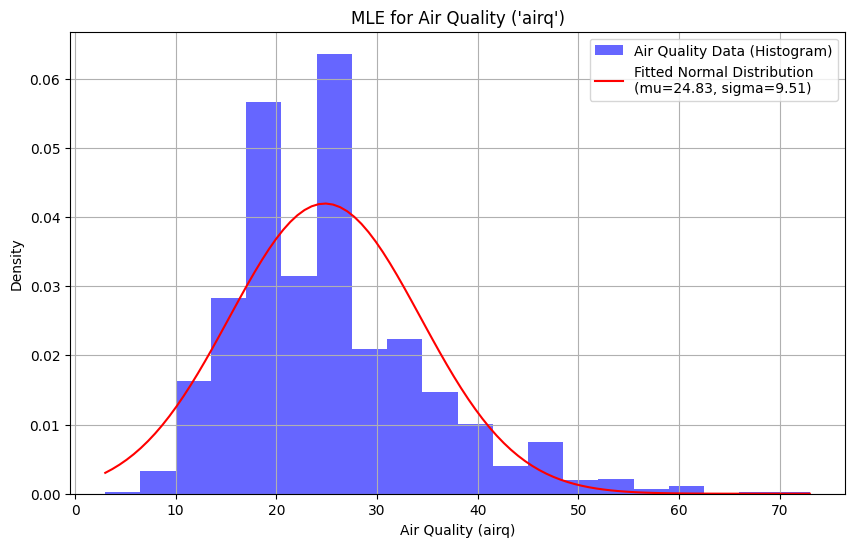

In [35]:
plt.figure(figsize=(10, 6))
plt.hist(airq_data, bins=20, density=True, alpha=0.6, color='blue', label="Air Quality Data (Histogram)")

x = np.linspace(airq_data.min(), airq_data.max(), 100)
y = norm.pdf(x, loc=mle_mu, scale=mle_sigma)
plt.plot(x, y, 'r-', label=f"Fitted Normal Distribution\n(mu={mle_mu:.2f}, sigma={mle_sigma:.2f})")

plt.title("MLE for Air Quality ('airq')")
plt.xlabel("Air Quality (airq)")
plt.ylabel("Density")
plt.legend()
plt.grid()
plt.show()
